### ASTR 8070: Astrostatistics
***N. Pol***
___

# Homework 5
### Due: Friday, Mar 7nd at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (100 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import scipy.optimize as ot
import dynesty


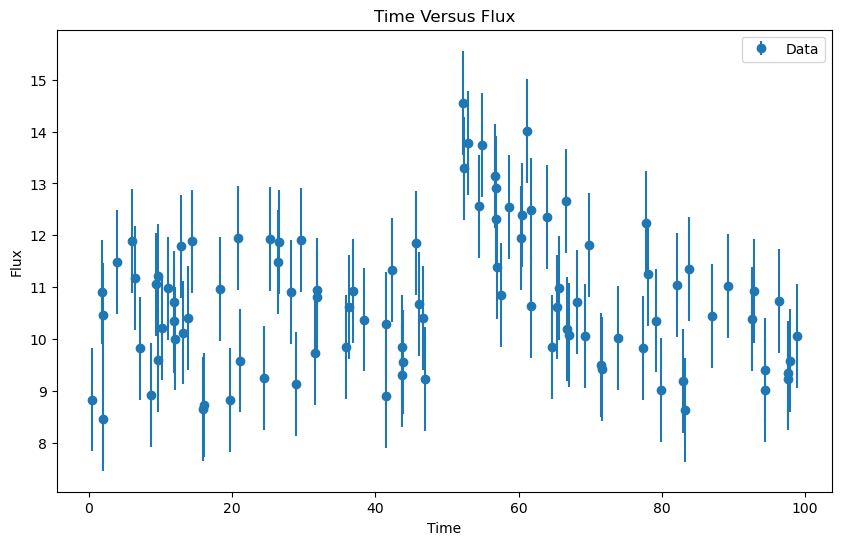

In [55]:
#Part 1
data = np.load('C:/Users/jeell/OneDrive/Documents/GitHub/ASTR_3300_S2025/coursework/homeworks/hw_data/hw5_data_1.npy')
t = data[:,0] 
f = data[:,1]
f_e = data[:,2]

plt.figure(figsize=(10,6))
plt.errorbar(t, f, yerr=f_e, fmt='o', label='Data')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Time Versus Flux')
plt.legend()
plt.show()

In [57]:
# Part 2
def b_model(t, b, A, t0, alpha):
    y = np.where(t<t0, b, b + A*np.exp(-alpha*(t-t0)))
    return y

def ln_like(theta, t, y, yerr):
    b, A, t0, alpha = theta
    model = b_model(t, b, A, t0, alpha)
    sigma0 = yerr**2
    ln_l = -0.5*np.sum((y-model)**2 / sigma0 + np.log(2*np.pi*sigma0))
    return ln_l



In [59]:
# Part 3
def ln_prior(theta):
    b, A, t0, log_alpha = theta
    if 0<b<50 and 0<A<50 and 0<t0<100 and -5<log_alpha<5:
        ln_p = 0.0
        return ln_p
    ln_p = -np.inf
    return ln_p

def ln_prob(theta, t, y, yerr):
    lp = ln_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    ln_pr = lp + ln_like(theta, t, y, yerr)
    return ln_pr

ndim, nwalkers = 4, 32
p0 = np.random.rand(nwalkers, ndim)
p0[:, 0] *= 50
p0[:, 1] *= 50
p0[:, 2] *= 100
p0[:, 3] = np.random.uniform(-5,5, nwalkers)

s = emcee.EnsembleSampler(nwalkers, ndim, ln_prob, args=(t, f, f_e))
s.run_mcmc(p0, 50000, progress=True)



C:\Users\jeell\AppData\Local\Temp\ipykernel_12396\1749186282.py:10: RuntimeWarning: overflow encountered in square
  ln_l = -0.5*np.sum((y-model)**2 / sigma0 + np.log(2*np.pi*sigma0))
100%|██████████| 50000/50000 [00:30<00:00, 1632.00it/s]


State([[10.39858741  5.95252964 50.52963811  0.14873884]
 [10.42583247  7.78869593 50.13640169  0.20449879]
 [10.40957408  7.04910772 48.46852437  0.14487729]
 [10.44605988  6.09344629 48.17434058  0.12827224]
 [10.33538207  6.02689976 48.55271108  0.12442529]
 [10.26349548  3.74470344 51.91561137  0.11681223]
 [10.47443664  6.31647923 47.41103898  0.12165728]
 [10.20836093  6.30308489 48.98021961  0.11926995]
 [10.80598356  3.12647966  7.94838381  3.82986251]
 [10.52854414  7.30264994 49.29328406  0.19183074]
 [10.11924119  4.37442183 50.53161102  0.11480421]
 [10.33131795 12.03393171 46.9880289   0.16578861]
 [10.31646715  6.56971292 47.32387221  0.136732  ]
 [10.27746292  4.72194984 50.13268772  0.09129927]
 [10.33187269  6.26181157 47.78384037  0.11494378]
 [10.27764176  5.47230332 49.39241981  0.13480242]
 [10.18021393  5.50995035 48.05560479  0.09347497]
 [10.41665591  9.17329728 47.00929066  0.13578331]
 [10.43316125  5.26623962 49.60649654  0.1221802 ]
 [10.44698472  7.68594942

In [61]:
# Part 4
tau = s.get_autocorr_time()
burn = int(2*np.max(tau))
thin = int(0.5 * np.min(tau))
sam = s.get_chain(discard=burn, thin=thin, flat=True)


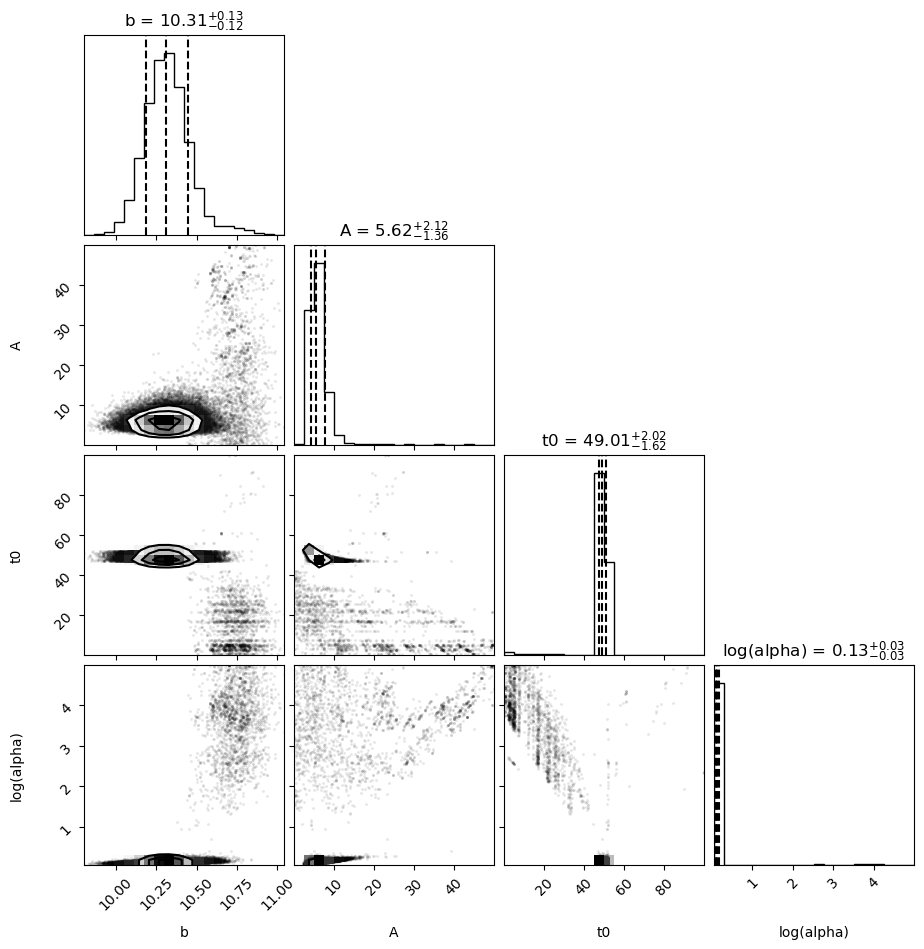

In [63]:
# Part 5
labels = ['b', 'A', 't0', 'log(alpha)']
corner.corner(sam, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True)
plt.show()

C:\Users\jeell\AppData\Local\Temp\ipykernel_12396\1749186282.py:3: RuntimeWarning: overflow encountered in exp
  y = np.where(t<t0, b, b + A*np.exp(-alpha*(t-t0)))


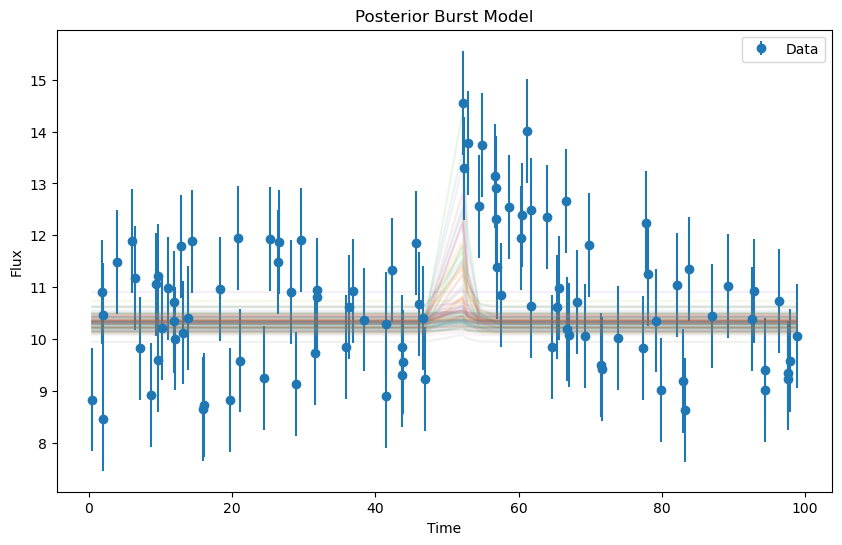

In [65]:
# Part 6
plt.figure(figsize=(10,6))
plt.errorbar(t, f, yerr=f_e, fmt='o', label='Data')
for s0 in sam[np.random.randint(len(sam), size=100)]:
    plt.plot(t, b_model(t, *s0[:3], np.exp(s0[3])), alpha=0.1)
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Posterior Burst Model')
plt.legend()
plt.show()


In [71]:
# Part 7
def g_model(t, b, A, t0, l_s_w):
    s_w = np.exp(l_s_w)
    g_m = b + A*np.exp(-(t-t0)**2 / (2 * s_w**2))
    return g_m

def lnl_g(theta, t, y, yerr):
    b, A, t0, l_s_w = theta
    model = g_model(t, b, A, t0, l_s_w)
    sig = yerr**2
    ln_g = -0.5 * np.sum((y-model)**2 / sig + np.log(2*np.pi*sig))
    return ln_g

def prior_transform_g(u):
    b = 50*u[0]
    A = 50*u[1]
    t0 = 100*u[2]
    l_s_w = -2 + 4*u[3]
    p_t_g = np.array([b, A, t0, l_s_w])
    return p_t_g

s_g = dynesty.NestedSampler(lnl_g, prior_transform_g, 4, nlive=1000, bound='multi', sample='rwalk', update_interval=1.0, logl_args=(t, f, f_e))
s_g.run_nested()
r_g = s_g.results

def prior_transform_b(u):
    b = 50*u[0]
    A = 50*u[1]
    t0 = 100*u[2]
    l_a = -5 + 10*u[3]
    p_t_b = np.array([b, A, t0, l_a])
    return p_t_b

s_b = dynesty.NestedSampler(ln_like, prior_transform_b, 4, nlive=1000, bound='multi', sample='rwalk', update_interval=1.0, logl_args=(t, f, f_e))
s_b.run_nested()
r_b = s_b.results

lnZ_g = r_g.logz[-1]
lnZ_b = r_b.logz[-1]

b_f = np.exp(lnZ_b - lnZ_g)
print(f"Bayes Factor (Burst/Gaussian): {b_f}")

if b_f > 1:
    print("The burst model is favored.")
else:
    print("The Gaussian model is favored.")

15790it [00:23, 671.21it/s, +1000 | bound: 292 | nc: 1 | ncall: 330512 | eff(%):  5.095 | loglstar:   -inf < -144.307 <    inf | logz: -160.107 +/-  0.135 | dlogz:  0.001 >  1.009]
C:\Users\jeell\AppData\Local\Temp\ipykernel_12396\1749186282.py:10: RuntimeWarning: overflow encountered in square
  ln_l = -0.5*np.sum((y-model)**2 / sigma0 + np.log(2*np.pi*sigma0))
2527it [00:00, 5111.05it/s, bound: 0 | nc: 12 | ncall: 12623 | eff(%): 20.019 | loglstar:   -inf < -1170.744 <    inf | logz: -1180.711 +/-    nan | dlogz: 1007.877 >  1.009]C:\Users\jeell\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
16752it [00:25, 657.57it/s, +1000 | bound: 315 | nc: 1 | ncall: 353109 | eff(%):  5.042 | loglstar:   -inf < -140.667 <    inf | logz: -157.316 +/-    nan | dlogz:  0.001 >  1.009]

Bayes Factor (Burst/Gaussian): 16.294220456438715
The burst model is favored.
